In [1]:
import pandas as pd
import numpy as np
import os
import pickle
import torch
import sys
from helpers_task_detector import *
sys.path.append('../')
from src.helpers import *
from src.visualize import *
from src.trainer import *
from src.trainer_hnet import * 
from Models.models import *
import json

import seaborn as sns
import matplotlib.pyplot as plt

/home/nerea/anaconda3/envs/sinthlab/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Load the list of experiments from JSON
with open(os.path.join('config.json'), 'r') as f:
    experiments = json.load(f)
    
path_to_hnets = './Models/Models_HNET_Block3'

In [4]:
experiment0_hnet_v0 = 'Experiment6_Task3'
models_exp0_hnet_v0 = np.sort(os.listdir(os.path.join(path_to_hnets, experiment0_hnet_v0)))


path_results_exp0_v0 = './Results/' + experiment0_hnet_v0
with open(os.path.join(path_results_exp0_v0 +'.pkl'), 'rb') as fp:
    results_hnet_exp0_v0 = pickle.load(fp)

data_path_exp0_v0 = './Data/Sim_Data_Experiment60_sorted_doubles'+'.pkl'
with open(os.path.join(data_path_exp0_v0), 'rb') as fp:
    data_exp0_v0 = pickle.load(fp)

In [5]:
model1 = torch.load(os.path.join(path_to_hnets,experiment0_hnet_v0, models_exp0_hnet_v0[1] ))
model2 = torch.load(os.path.join(path_to_hnets,experiment0_hnet_v0, models_exp0_hnet_v0[2] ))
model9 = torch.load(os.path.join(path_to_hnets,experiment0_hnet_v0, models_exp0_hnet_v0[7] ))

In [6]:
first_task = list(data_exp0_v0.keys())[1]

In [7]:
x_train, y_train, x_val, y_val, x_test, y_test = data_exp0_v0[first_task]
W_1 = model1(cond_id = 1)
W_2 = model2(cond_id = 1)
W_9 = model9(cond_id = 1)

In [8]:
main_net = RNN_Main_Model(num_features= 130, hnet_output = W_1,  hidden_size = 300,
                                        num_layers= 1,out_dims=2,  
                                        dropout= 0.2,  LSTM_ = False)

In [9]:
r2_1, _ = calc_explained_variance_mnet(x_test, y_test, W_1, main_net)

In [10]:
r2_1

0.8131134510040283

In [11]:
r2_2, _ = calc_explained_variance_mnet(x_test, y_test, W_2, main_net)


In [12]:
r2_2

0.7684858441352844

In [13]:
r2_9, _ = calc_explained_variance_mnet(x_test, y_test, W_9, main_net)

In [14]:
r2_9

0.7448392510414124

In [15]:
task_performances = {}
best_perf = {}
for d in data_exp0_v0.keys():
    x_train, y_train, x_val, y_val, x_test, y_test = data_exp0_v0[d]
    data_perf = []
    model = torch.load(os.path.join(path_to_hnets,experiment0_hnet_v0, models_exp0_hnet_v0[-1] ))
    for cond in range(len(models_exp0_hnet_v0)):
        W = model(cond_id = cond)
        r2_, _ = calc_explained_variance_mnet(x_test, y_test, W, main_net)
        data_perf.append(r2_)
    task_performances[d] = data_perf
    best_perf[d] = max(data_perf)


In [16]:
best_perf

{'Data_0_1': 0.8191485106945038,
 'Data_2_2': 0.747071772813797,
 'Data_4_1': 0.8458623886108398,
 'Data_3_1': 0.7630740106105804,
 'Data_1_2': 0.7441223859786987,
 'Data_0_1_copy': 0.8194865882396698,
 'Data_2_2_copy': 0.743860125541687,
 'Data_4_1_copy': 0.8439207375049591,
 'Data_3_1_copy': 0.7601103484630585,
 'Data_1_2_copy': 0.7431228160858154}

In [17]:
results_hnet_exp0_v0['Data_0_1'].keys()

dict_keys(['y_true_hnet', 'y_pred_hnet', 'r2_test_hnet', 'hnet_train_losses', 'hnet_val_losses', 'training_time', 'change_detect_epoch', 'prev_active_context', 'prev_min_loss', 'prev_mean_loss', 'new_tested_context', 'new_loss', 'new_mean_loss'])

In [18]:
keys_to_extract = ['change_detect_epoch', 'prev_active_context', 'prev_min_loss', 'prev_mean_loss', 'new_tested_context', 'new_loss', 'new_mean_loss']


In [19]:
# Move tensors to CPU and convert to lists, handle non-tensor values appropriately
def generate_dict_changes(dataset, keys_to_extract):
    filtered_data = {}
    results = results_hnet_exp0_v0[dataset]
    for key in keys_to_extract:
        if key in results:
            value = results[key]
            if isinstance(value[0], torch.Tensor):
                filtered_data[key] = [tensor.cpu().item() for tensor in value]
            else:
                filtered_data[key] = value
    return pd.DataFrame(filtered_data)
    

In [20]:
keys = list(results_hnet_exp0_v0.keys())
data_dict1 = generate_dict_changes(keys[1], keys_to_extract)
data_dict2 = generate_dict_changes(keys[2], keys_to_extract)
data_dict3 = generate_dict_changes(keys[3], keys_to_extract)
data_dict4 = generate_dict_changes(keys[4], keys_to_extract)
data_dict5 = generate_dict_changes(keys[5], keys_to_extract)
data_dict6 = generate_dict_changes(keys[6], keys_to_extract)
data_dict7 = generate_dict_changes(keys[7], keys_to_extract)
data_dict8 = generate_dict_changes(keys[8], keys_to_extract)
data_dict9 = generate_dict_changes(keys[9], keys_to_extract)
dataframes = [data_dict1, data_dict2, data_dict3, data_dict4, data_dict5, data_dict6, data_dict7, data_dict8, data_dict9]
df_changes = pd.concat(dataframes, ignore_index=True)

In [21]:
df_changes

,change_detect_epoch,prev_active_context,prev_min_loss,prev_mean_loss,new_tested_context,new_loss,new_mean_loss
0,0,0,4.091286,1.632112,0,7.329899,1.632112
1,0,1,4.768394,1.917381,0,19.865381,1.632112
2,0,1,4.768394,1.917381,1,10.722637,1.917381
3,0,2,7.571535,2.567626,0,14.645447,1.632112
4,0,2,7.571535,2.567626,1,19.017685,1.917381
5,0,2,7.571535,2.567626,2,12.980361,2.567626
6,0,3,6.995373,2.214444,0,22.058777,1.632112
7,0,3,6.995373,2.214444,1,19.706015,1.917381
8,0,3,6.995373,2.214444,2,10.954532,2.567626
9,0,3,6.995373,2.214444,3,7.054825,2.214444


In [22]:
results_hnet_exp0_v0['Data_4_1']['new_tested_context']

[0, 1]

In [23]:
results_hnet_exp0_v0.keys()

dict_keys(['Data_0_1', 'Data_2_2', 'Data_4_1', 'Data_3_1', 'Data_1_2', 'Data_0_1_copy', 'Data_2_2_copy', 'Data_4_1_copy', 'Data_3_1_copy', 'Data_1_2_copy'])

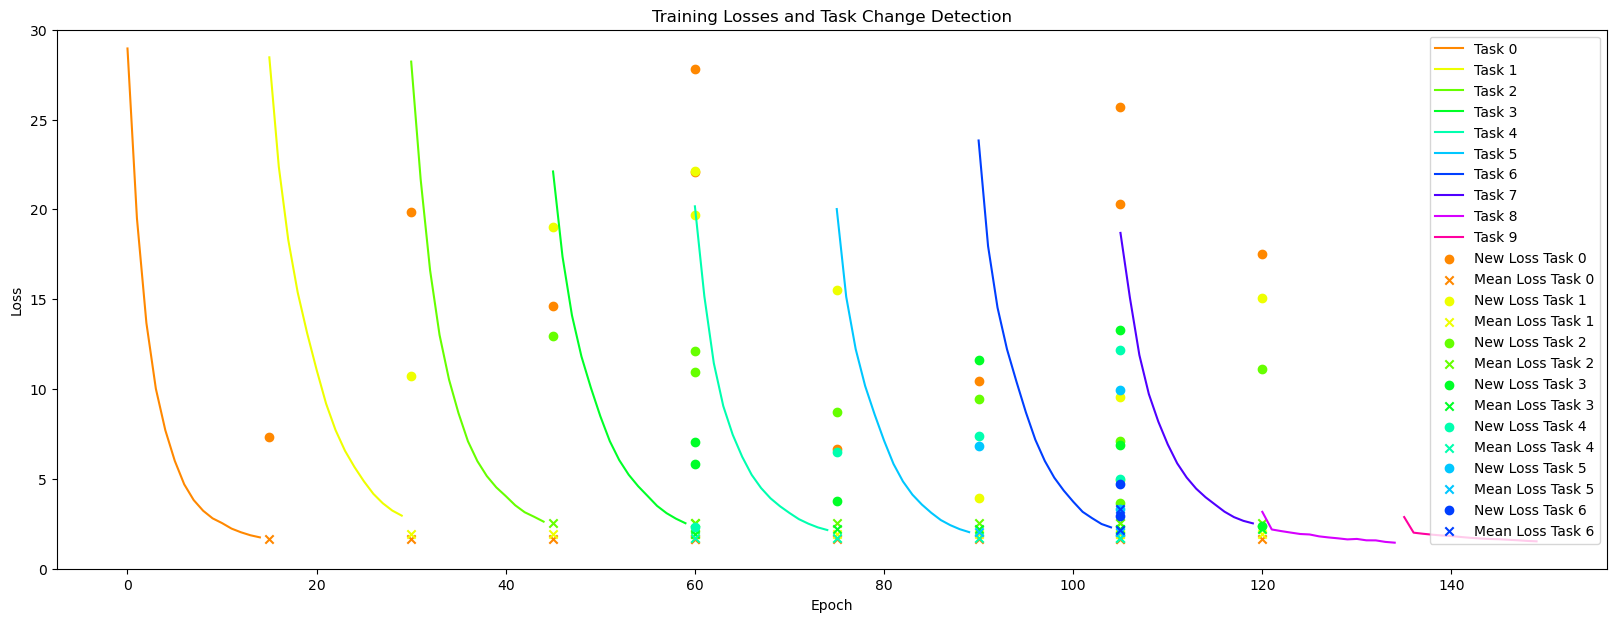

In [24]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

# Sample DataFrame creation for demonstration (you can skip this if you already have df_changes)
# df_changes = pd.read_csv('path_to_your_dataframe.csv')  # Use this line to load your DataFrame

# Assuming df_changes and results_hnet_exp0_v0 are already defined

# Plot settings
plt.figure(figsize=[20, 7])

# Example epochs
epochs = [15, 30, 45, 60, 75, 90, 105, 120, 135]
epochs_task = np.cumsum([0] + epochs)

# Plot the training losses for each task
task_data_keys = list(results_hnet_exp0_v0.keys())
unique_tasks = range(len(task_data_keys))
colors = sns.color_palette("hsv", len(unique_tasks))
color_map = {task: colors[i] for i, task in enumerate(unique_tasks)}

for i, key in enumerate(task_data_keys):
    if i < len(task_data_keys):
        start_epoch = i * 15
        end_epoch = (i + 1) * 15
        plt.plot(
            np.arange(start_epoch, end_epoch), 
            results_hnet_exp0_v0[key]['hnet_train_losses'], 
            label=f'Task {i}',
            color=color_map[i]
        )

# Scatter plot for change detection and losses
for new_task in df_changes.new_tested_context.unique():
    data_new_task = df_changes[df_changes.new_tested_context == new_task]
    plt.scatter(
        (data_new_task.prev_active_context + 1) * 15, 
        data_new_task['new_loss'], 
        color=color_map[new_task], 
        label=f'New Loss Task {new_task}', 
        marker='o'
    )
    plt.scatter(
        (data_new_task.prev_active_context + 1) * 15, 
        data_new_task['new_mean_loss'], 
        color=color_map[new_task], 
        label=f'Mean Loss Task {new_task}', 
        marker='x'
    )

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Losses and Task Change Detection')
plt.legend(loc='upper right')
plt.ylim([0, 30])
plt.show()


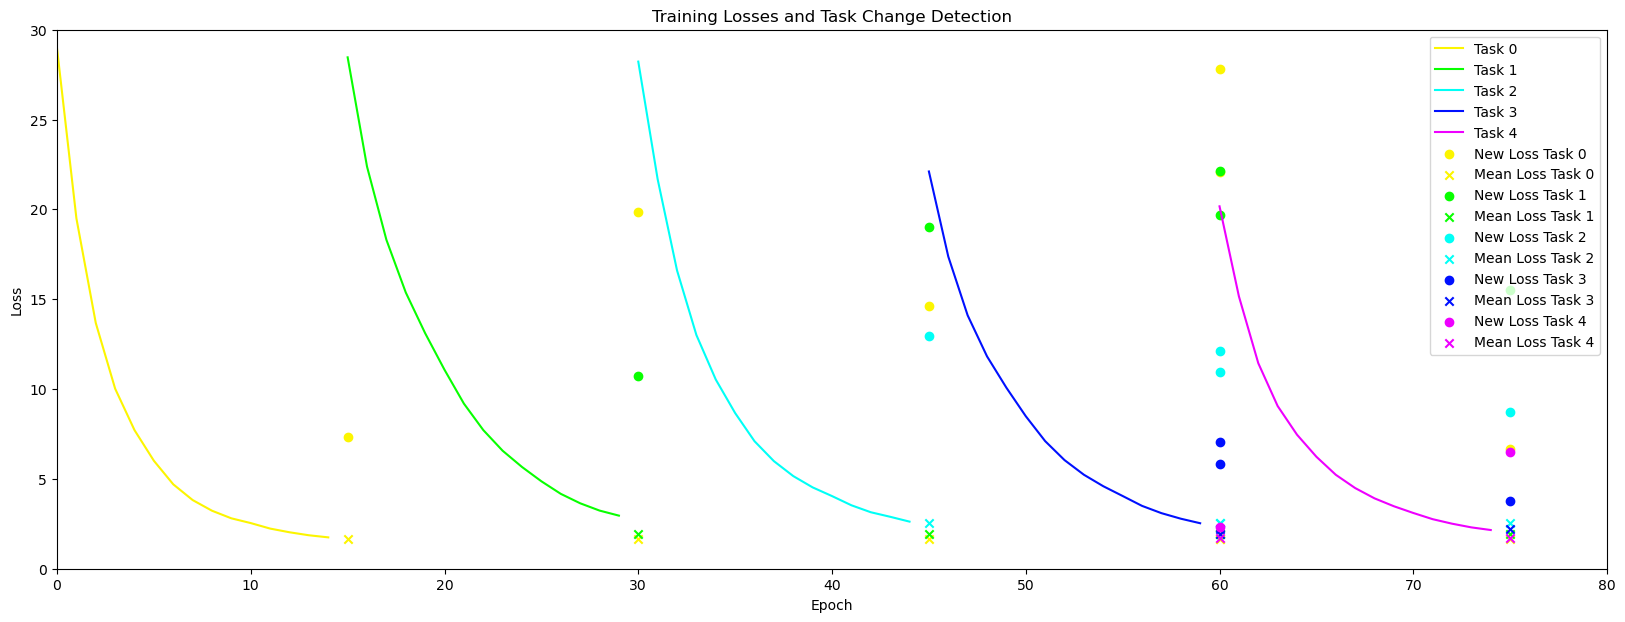

In [25]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

# Sample DataFrame creation for demonstration (you can skip this if you already have df_changes)
# df_changes = pd.read_csv('path_to_your_dataframe.csv')  # Use this line to load your DataFrame

# Assuming df_changes and results_hnet_exp0_v0 are already defined

# Plot settings
plt.figure(figsize=[20, 7])

# Example epochs
epochs = [15, 30, 45, 60, 75]
epochs_task = np.cumsum([0] + epochs)

# Plot the training losses for the first 5 tasks
task_data_keys = list(results_hnet_exp0_v0.keys())[:5]
unique_tasks = range(len(task_data_keys))
colors = sns.color_palette("hsv", len(unique_tasks))
color_map = {task: colors[i] for i, task in enumerate(unique_tasks)}

for i, key in enumerate(task_data_keys):
    start_epoch = i * 15
    end_epoch = (i + 1) * 15
    plt.plot(
        np.arange(start_epoch, end_epoch), 
        results_hnet_exp0_v0[key]['hnet_train_losses'], 
        label=f'Task {i}',
        color=color_map[i]
    )

# Scatter plot for change detection and losses
for new_task in df_changes.new_tested_context.unique():
    if new_task < 5:  # Only include the first 5 tasks
        data_new_task = df_changes[df_changes.new_tested_context == new_task]
        plt.scatter(
            (data_new_task.prev_active_context + 1) * 15, 
            data_new_task['new_loss'], 
            color=color_map[new_task], 
            label=f'New Loss Task {new_task}', 
            marker='o'
        )
        plt.scatter(
            (data_new_task.prev_active_context + 1) * 15, 
            data_new_task['new_mean_loss'], 
            color=color_map[new_task], 
            label=f'Mean Loss Task {new_task}', 
            marker='x'
        )

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Losses and Task Change Detection')
plt.legend(loc='upper right')
plt.ylim([0, 30])
plt.xlim([0,80])
plt.show()
